# Step by step: Feature Engineering on Time-Series Data for Human Activity Recognition, by Pratik Nabriya [[source](https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60)]

In [1]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
har_df = pd.read_csv('../datasets/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

# removing null values
har_df = har_df.dropna()
har_df.shape

# transforming the z-axis to float
har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [2]:
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


## Exploratory Data Analysis (EDA)

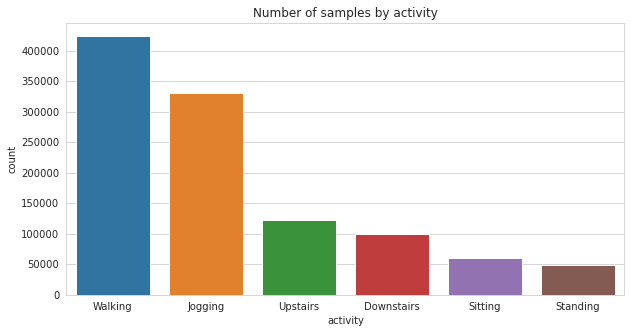

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

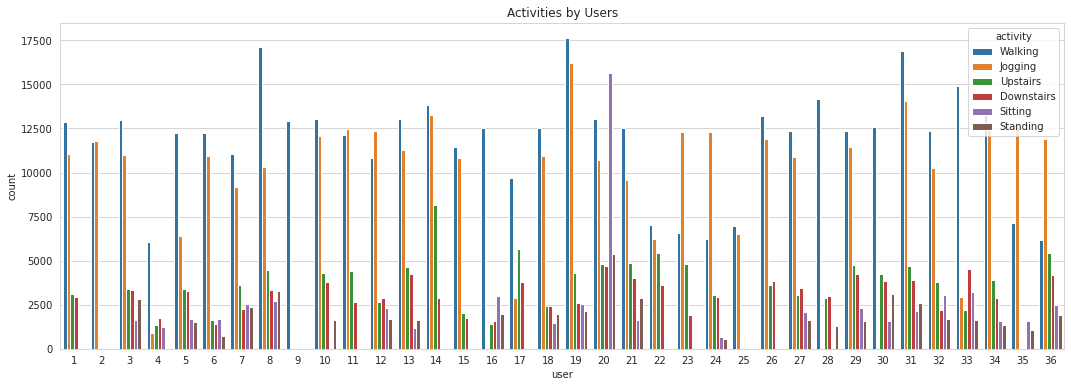

In [6]:
plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = df)
plt.title('Activities by Users')
plt.show()

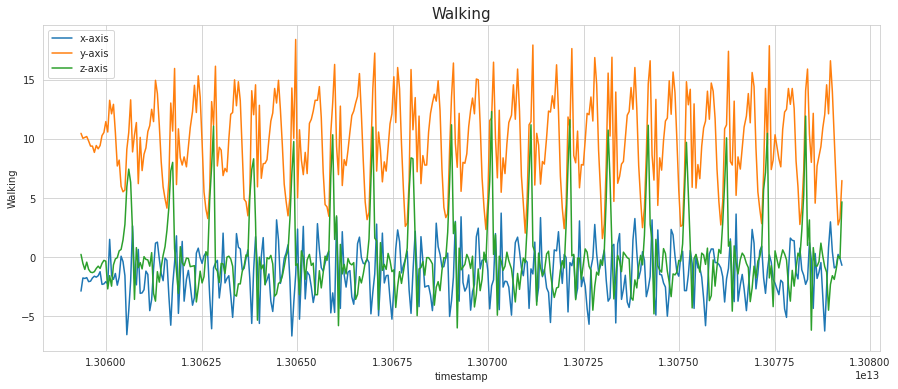

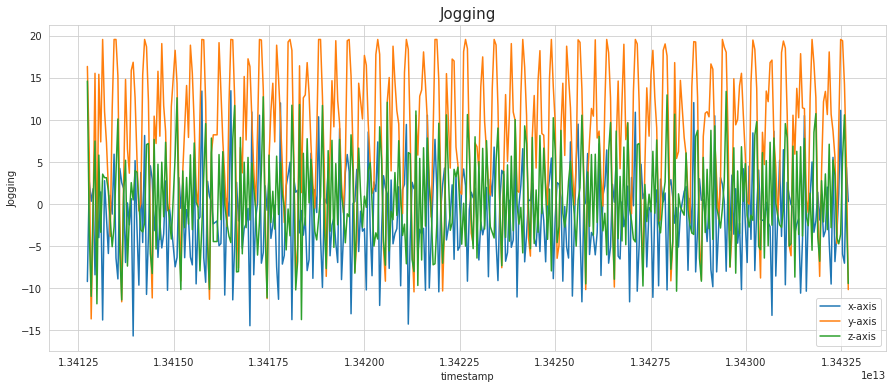

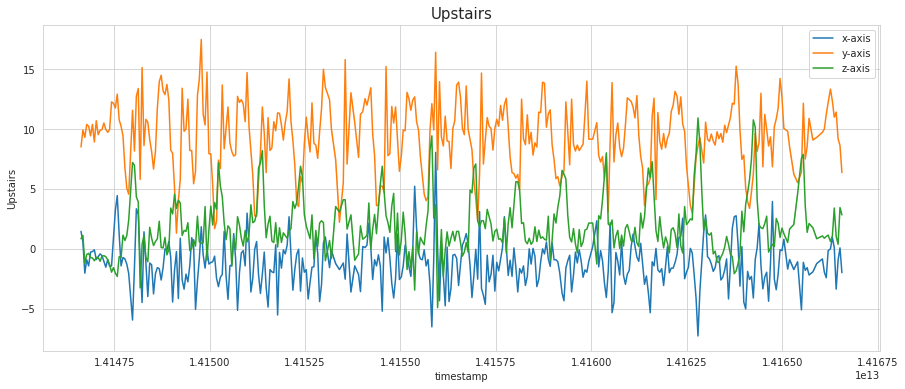

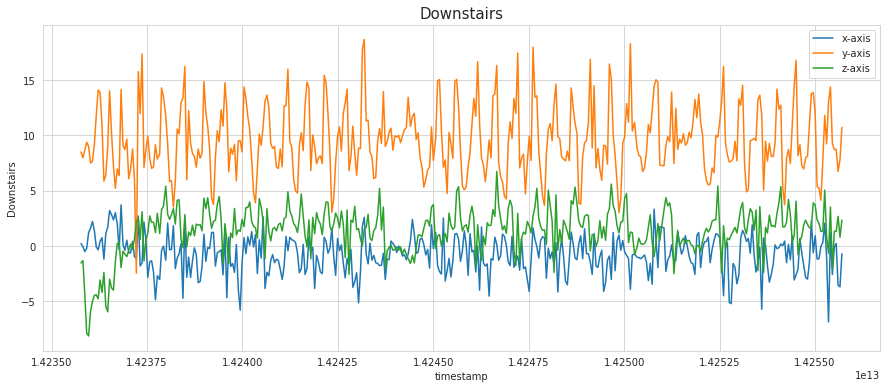

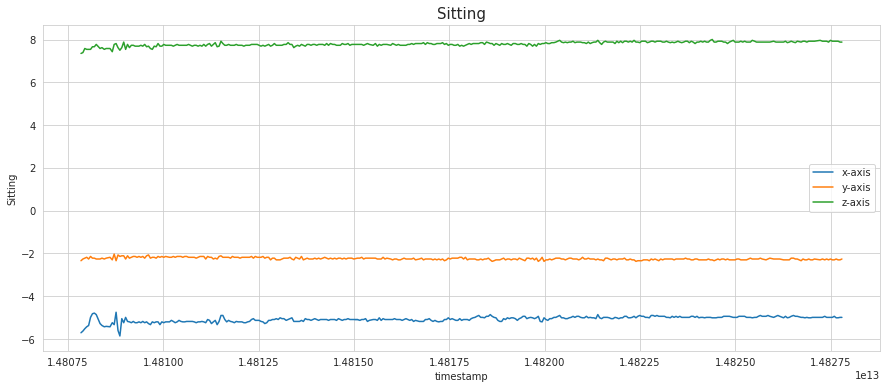

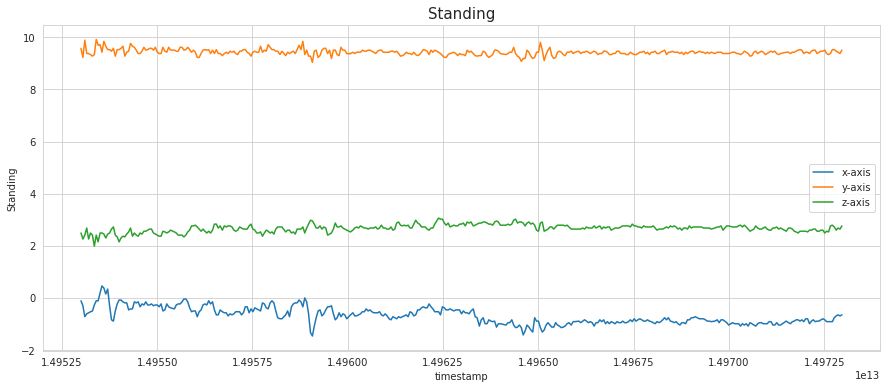

In [4]:
for i in ['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']:
    data_36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    plt.figure(figsize=(15,6))
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data_36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data_36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data_36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()


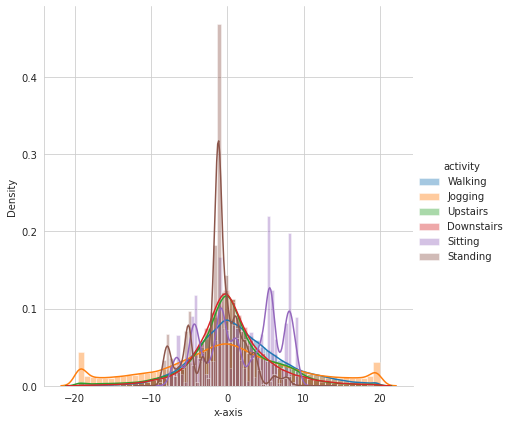

In [5]:
sns.FacetGrid(df, hue='activity', size=6).map(sns.distplot, 'x-axis').add_legend()

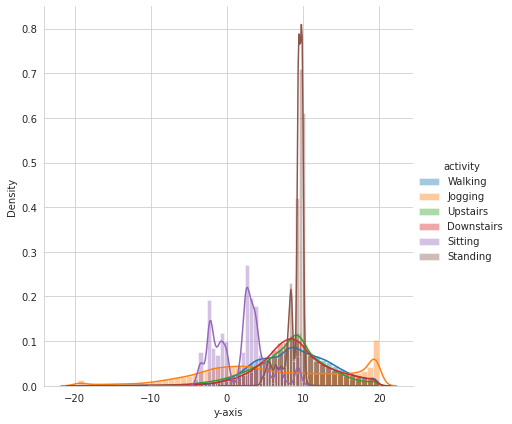

In [6]:
sns.FacetGrid(df, hue='activity', size=6).map(sns.distplot, 'y-axis').add_legend()

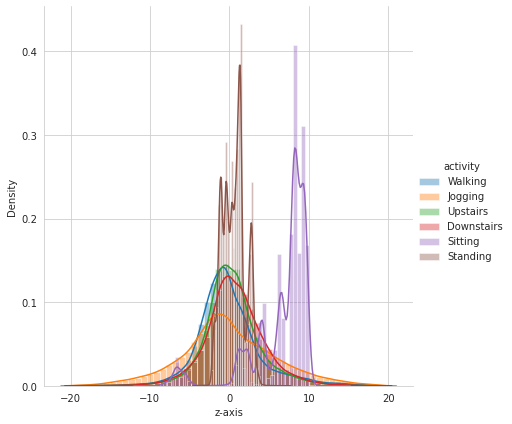

In [7]:
sns.FacetGrid(df, hue='activity', size=6).map(sns.distplot, 'z-axis').add_legend()

## Data Transformation

In [8]:
# train_data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]
# test_data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

### Statistical measures

In [9]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x-axis'].values[i: i + 100]
    ys = df_train['y-axis'].values[i: i + 100]
    zs = df_train['z-axis'].values[i: i + 100]
    label = stats.mode(df_train['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

### Fast-Fourier transform (FFT)

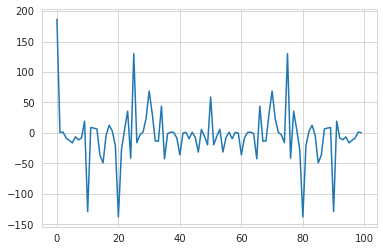

In [10]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

In [11]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

### Capturing indices

In [12]:
# Max Indices and Min indices 

# index of max value in time domain
X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

# index of max value in frequency domain
X_train['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_train['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])

### AIO
1. Statistical measures
2. Fast Fourier transform
3. Capturing indices

In [14]:
def transform_data(origin, destiny, stage_labels):
    x_list = []
    y_list = []
    z_list = []
    

    window_size = 100
    step_size = 50

    # creating overlaping windows of size window-size 100
    for i in range(0, origin.shape[0] - window_size, step_size):
        xs = origin['x-axis'].values[i: i + 100]
        ys = origin['y-axis'].values[i: i + 100]
        zs = origin['z-axis'].values[i: i + 100]
        label = stats.mode(origin['activity'][i: i + 100])[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        stage_labels.append(label)

    

    # mean
    destiny['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    destiny['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
    destiny['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

    # std dev
    destiny['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    destiny['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    destiny['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # avg absolute diff
    destiny['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    destiny['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    destiny['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    destiny['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
    destiny['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
    destiny['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

    # max
    destiny['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
    destiny['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
    destiny['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

    # max-min diff
    destiny['x_maxmin_diff'] = destiny['x_max'] - destiny['x_min']
    destiny['y_maxmin_diff'] = destiny['y_max'] - destiny['y_min']
    destiny['z_maxmin_diff'] = destiny['z_max'] - destiny['z_min']

    # median
    destiny['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
    destiny['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
    destiny['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

    # median abs dev 
    destiny['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    destiny['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    destiny['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    destiny['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    destiny['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    destiny['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    destiny['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
    destiny['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
    destiny['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

    # positive count
    destiny['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
    destiny['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
    destiny['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

    # values above mean
    destiny['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
    destiny['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
    destiny['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    destiny['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
    destiny['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
    destiny['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

    # skewness
    destiny['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
    destiny['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
    destiny['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

    # kurtosis
    destiny['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
    destiny['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
    destiny['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

    # energy
    destiny['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
    destiny['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
    destiny['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

    # avg resultant
    destiny['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

    # signal magnitude area
    destiny['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                    + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

    #--

    # converting the signals from time domain to frequency domain using FFT
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    destiny['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    destiny['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    destiny['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

    # FFT std dev
    destiny['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    destiny['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    destiny['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    destiny['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    destiny['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    destiny['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    destiny['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    destiny['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    destiny['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    destiny['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    destiny['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    destiny['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT max-min diff
    destiny['x_maxmin_diff_fft'] = destiny['x_max_fft'] - destiny['x_min_fft']
    destiny['y_maxmin_diff_fft'] = destiny['y_max_fft'] - destiny['y_min_fft']
    destiny['z_maxmin_diff_fft'] = destiny['z_max_fft'] - destiny['z_min_fft']

    # FFT median
    destiny['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    destiny['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    destiny['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    destiny['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    destiny['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    destiny['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    destiny['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    destiny['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    destiny['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT values above mean
    destiny['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
    destiny['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
    destiny['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

    # FFT number of peaks
    destiny['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    destiny['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    destiny['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

    # FFT skewness
    destiny['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
    destiny['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
    destiny['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

    # FFT kurtosis
    destiny['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
    destiny['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
    destiny['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

    # FFT energy
    destiny['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
    destiny['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
    destiny['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

    # FFT avg resultant
    destiny['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    destiny['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                        + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

    #--

    # Max Indices and Min indices 

    # index of max value in time domain
    destiny['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
    destiny['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
    destiny['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

    # index of min value in time domain
    destiny['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
    destiny['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
    destiny['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

    # absolute difference between above indices
    destiny['x_arg_diff'] = abs(destiny['x_argmax'] - destiny['x_argmin'])
    destiny['y_arg_diff'] = abs(destiny['y_argmax'] - destiny['y_argmin'])
    destiny['z_arg_diff'] = abs(destiny['z_argmax'] - destiny['z_argmin'])

    # index of max value in frequency domain
    destiny['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    destiny['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    destiny['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

    # index of min value in frequency domain
    destiny['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    destiny['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    destiny['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

    # absolute difference between above indices
    destiny['x_arg_diff_fft'] = abs(destiny['x_argmax_fft'] - destiny['x_argmin_fft'])
    destiny['y_arg_diff_fft'] = abs(destiny['y_argmax_fft'] - destiny['y_argmin_fft'])
    destiny['z_arg_diff_fft'] = abs(destiny['z_argmax_fft'] - destiny['z_argmin_fft'])

In [15]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()
X_test = pd.DataFrame()
train_labels = []
test_labels = []

transform_data(df_train, X_train, train_labels)
transform_data(df_test, X_test, test_labels)

In [16]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8421427300231358

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.69      0.75      0.72       576
     Jogging       0.82      0.94      0.88      1522
     Sitting       0.84      1.00      0.91       361
    Standing       0.96      0.80      0.87       323
    Upstairs       0.70      0.64      0.67       640
     Walking       0.94      0.84      0.89      2197

    accuracy                           0.84      5619
   macro avg       0.82      0.83      0.82      5619
weighted avg       0.85      0.84      0.84      5619



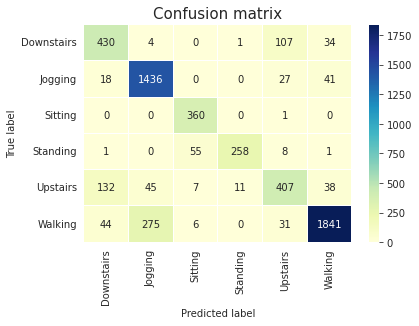

In [18]:
from sklearn.metrics import confusion_matrix

labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()